In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import re
import string

In [80]:
def tokenize(doc):

    tokens = []
    stop_words = set(stopwords.words('english'))
    stop_words.update(['us','ve','nt','re','ll','wo','ca','m','s','t','``','...','-','—',' ','laughter','applause', 'ok', 'oh','talk','make','ted'])
    wordnet_lemmatizer = WordNetLemmatizer()

    def nltk_tag_to_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else: 
            #return default value
            return wordnet.NOUN

    tokens =[wordnet_lemmatizer.lemmatize(token.strip(), nltk_tag_to_wordnet_tag(tag)) \
            for token, tag in nltk.pos_tag(nltk.word_tokenize(doc.lower()))\
            if token.strip() not in stop_words and\
            token.strip() not in string.punctuation]
    
    t = []
    for token in tokens:        
        if len(token) <= 1:
            tokens.remove(token)
        elif len(token) >1:
            t.append(token)
                           
    return t

def compute_tfidf(docs):
    
    smoothed_tf_idf, smoothed_idf, words = None, None, None
         
    docs_tokens={idx:nltk.FreqDist(tokenize(doc)) \
             for idx,doc in enumerate(docs)}

    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    dtm=dtm.sort_index(axis=0)
    words = np.array(dtm.columns) 
       
    tf1=dtm.values
    doc_len=tf1.sum(axis=1)
    tf=np.divide(tf1.T, doc_len).T    
    df=np.where(tf>0,1,0)


    smoothed_idf = np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1      
    
    smoothed_tf_idf = normalize(tf*smoothed_idf)
    
    return smoothed_tf_idf, smoothed_idf, words

def vectorize_doc(doc, words, idf):
    
    vect = None   
    
    tokens = tokenize(doc)

    tf1 = np.zeros(len(words))   

    for token in tokens:
        for idx, word in enumerate(words):
            if token == word:
                tf1[idx] = tokens.count(token)
               
    tf = np.expand_dims(tf1, axis=0) 
    idf = np.expand_dims(idf,axis=0)

    vect = normalize(tf*idf)
    
    return vect

def find_answer(doc_vect, tf_idf, docs):
    
    top_docs  = []
    
    
    similarity=1-pairwise_distances( doc_vect,tf_idf, metric = 'cosine')
       
    idx = np.argsort(similarity)[:,::-1][0,0:11]
    
    top_docs.append(docs[idx])
        
    return top_docs

In [6]:
data1=pd.read_csv('big_data.csv',engine='python')
data2=pd.read_csv('sentiment_cluster_gmm.csv')
data1

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,views,transcript,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,47227110,Good morning. How are you?(Laughter)It's been ...,0.092794,0.114177,0.116472,0.132365,0.129963,0.105839,0.201247,0.107143
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,3200520,"Thank you so much, Chris. And it's truly a gre...",0.108238,0.111975,0.121799,0.134885,0.129981,0.107100,0.178588,0.107434
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun...",0.093672,0.123894,0.115410,0.138560,0.138518,0.108802,0.179580,0.101564
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,1697550,If you're here today ?�? and I'm very happy th...,0.105926,0.106197,0.128772,0.134356,0.121305,0.108597,0.182394,0.112452
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,12005869,"About 10 years ago, I took on the task to teac...",0.108617,0.112215,0.118959,0.129735,0.126809,0.107173,0.184243,0.112248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457,17,"Between 2008 and 2016, the United States depor...",476,TED2017,1496707200,4,Duarte Geraldino,Duarte Geraldino: What we're missing in the de...,1,1505851216,...,450430,"So, Ma was trying to explain something to me a...",0.102343,0.108939,0.131899,0.138636,0.126494,0.101510,0.174694,0.115485
2458,6,How can you study Mars without a spaceship? He...,290,TED2017,1492992000,3,Armando Azua-Bustos,Armando Azua-Bustos: The most Martian place on...,1,1505919737,...,417470,This is a picture of a sunset on Mars taken by...,0.120188,0.119194,0.114707,0.126044,0.117753,0.104346,0.175029,0.122739
2459,10,Science fiction visions of the future show us ...,651,TED2017,1492992000,1,Radhika Nagpal,Radhika Nagpal: What intelligent machines can ...,1,1506006095,...,375647,"In my early days as a graduate student, I went...",0.097120,0.131195,0.119608,0.129501,0.123598,0.106018,0.193803,0.099157
2460,32,In an unmissable talk about race and politics ...,1100,TEDxMileHigh,1499472000,1,Theo E.J. Wilson,Theo E.J. Wilson: A black man goes undercover ...,1,1506024042,...,419309,I took a cell phone and accidentally made myse...,0.094750,0.117907,0.122510,0.136626,0.131677,0.101304,0.191245,0.103982


In [7]:
data2

,url,sentiment_cluster
0,https://www.ted.com/talks/ken_robinson_says_sc...,3
1,https://www.ted.com/talks/al_gore_on_averting_...,8
2,https://www.ted.com/talks/david_pogue_says_sim...,2
3,https://www.ted.com/talks/majora_carter_s_tale...,0
4,https://www.ted.com/talks/hans_rosling_shows_t...,0
...,...,...
2457,https://www.ted.com/talks/duarte_geraldino_wha...,5
2458,https://www.ted.com/talks/armando_azua_bustos_...,4
2459,https://www.ted.com/talks/radhika_nagpal_what_...,1
2460,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,8


In [8]:
big_data = pd.merge(data1, data2, on=['url', 'url'],how= 'inner') 
big_data

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,transcript,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD,sentiment_cluster
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,Good morning. How are you?(Laughter)It's been ...,0.092794,0.114177,0.116472,0.132365,0.129963,0.105839,0.201247,0.107143,3
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,"Thank you so much, Chris. And it's truly a gre...",0.108238,0.111975,0.121799,0.134885,0.129981,0.107100,0.178588,0.107434,8
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",0.093672,0.123894,0.115410,0.138560,0.138518,0.108802,0.179580,0.101564,2
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,If you're here today ?�? and I'm very happy th...,0.105926,0.106197,0.128772,0.134356,0.121305,0.108597,0.182394,0.112452,0
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,"About 10 years ago, I took on the task to teac...",0.108617,0.112215,0.118959,0.129735,0.126809,0.107173,0.184243,0.112248,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,17,"Between 2008 and 2016, the United States depor...",476,TED2017,1496707200,4,Duarte Geraldino,Duarte Geraldino: What we're missing in the de...,1,1505851216,...,"So, Ma was trying to explain something to me a...",0.102343,0.108939,0.131899,0.138636,0.126494,0.101510,0.174694,0.115485,5
2464,6,How can you study Mars without a spaceship? He...,290,TED2017,1492992000,3,Armando Azua-Bustos,Armando Azua-Bustos: The most Martian place on...,1,1505919737,...,This is a picture of a sunset on Mars taken by...,0.120188,0.119194,0.114707,0.126044,0.117753,0.104346,0.175029,0.122739,4
2465,10,Science fiction visions of the future show us ...,651,TED2017,1492992000,1,Radhika Nagpal,Radhika Nagpal: What intelligent machines can ...,1,1506006095,...,"In my early days as a graduate student, I went...",0.097120,0.131195,0.119608,0.129501,0.123598,0.106018,0.193803,0.099157,1
2466,32,In an unmissable talk about race and politics ...,1100,TEDxMileHigh,1499472000,1,Theo E.J. Wilson,Theo E.J. Wilson: A black man goes undercover ...,1,1506024042,...,I took a cell phone and accidentally made myse...,0.094750,0.117907,0.122510,0.136626,0.131677,0.101304,0.191245,0.103982,8


In [9]:
big_data.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'transcript', 'AFRAID', 'AMUSED', 'ANGRY', 'ANNOYED',
       'DONT_CARE', 'HAPPY', 'INSPIRED', 'SAD', 'sentiment_cluster'],
      dtype='object')

In [114]:
big_data.isnull().any()

comments              False
description           False
duration              False
event                 False
film_date             False
languages             False
main_speaker          False
name                  False
num_speaker           False
published_date        False
ratings               False
related_talks         False
speaker_occupation     True
tags                  False
title                 False
url                   False
views                 False
transcript            False
AFRAID                False
AMUSED                False
ANGRY                 False
ANNOYED               False
DONT_CARE             False
HAPPY                 False
INSPIRED              False
SAD                   False
sentiment_cluster     False
dtype: bool

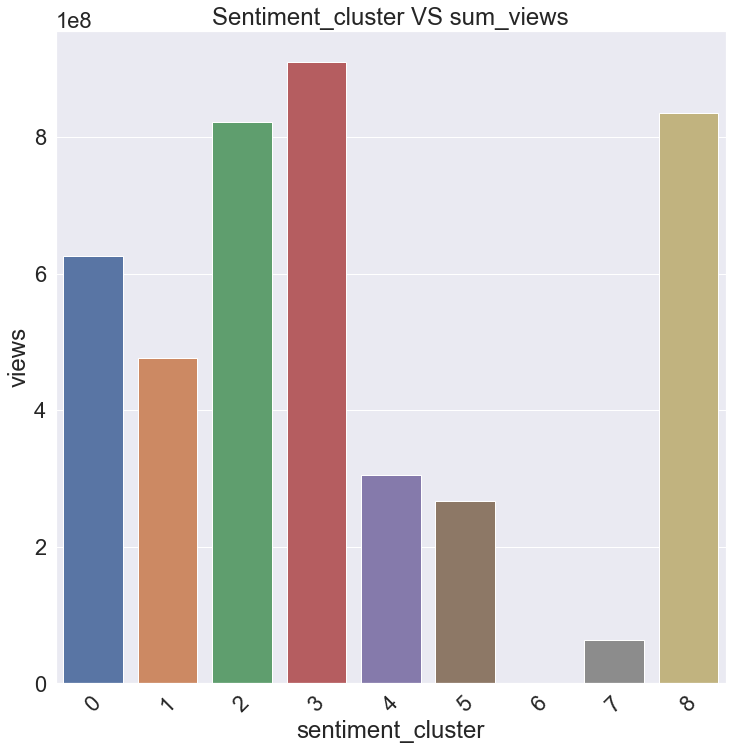

In [180]:
views = big_data.groupby('sentiment_cluster').views.agg(np.sum).reset_index()
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 2)
plt.figure(figsize=(12,12))
sns_plot = sns.barplot(x='sentiment_cluster', y='views', data=views)
plt.title('Sentiment_cluster VS sum_views')
plt.xticks(rotation=45)
plt.show()

In [137]:
fig = sns_plot.get_figure()
fig.savefig("sentiment_clusterVSviews.png")

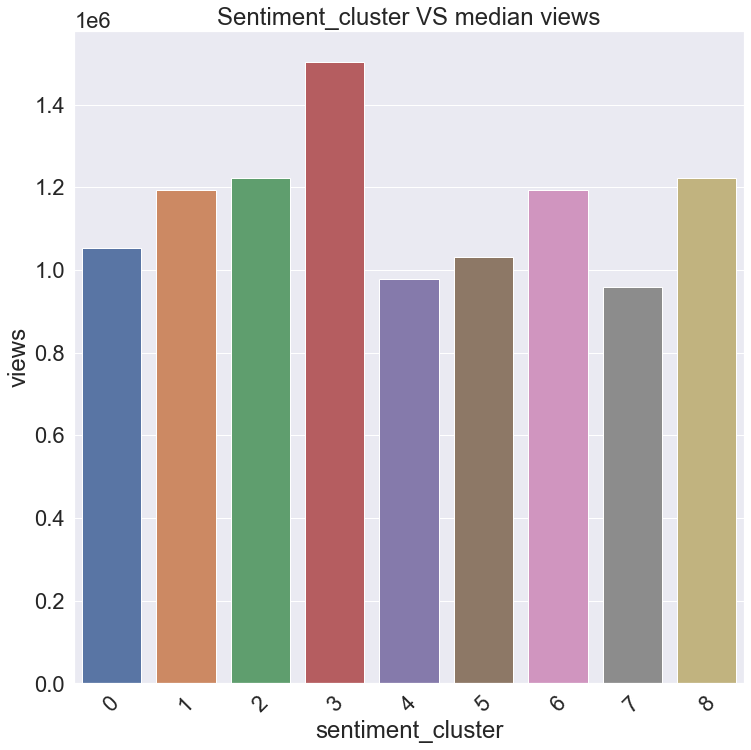

In [178]:
views = big_data.groupby('sentiment_cluster').views.agg(np.median).reset_index()
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 2)
plt.figure(figsize=(12,12))
fig = sns_plot = sns.barplot(x='sentiment_cluster', y='views', data=views)
plt.title('Sentiment_cluster VS median views')
plt.xticks(rotation=45)
plt.show()

In [179]:
fig = sns_plot.get_figure()
fig.savefig("sentiment_clusterVSmedian_views.png")

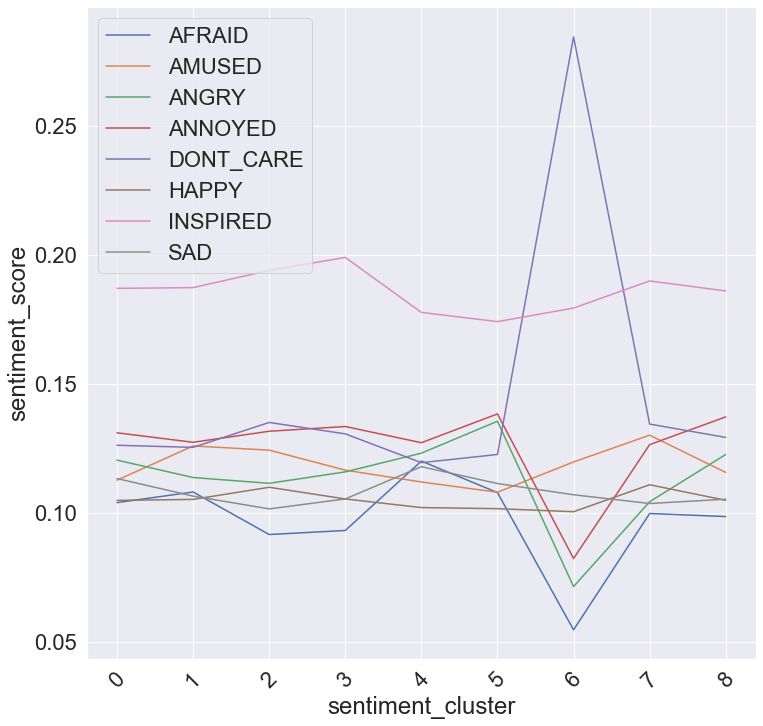

In [139]:
sentiment = big_data.groupby('sentiment_cluster').agg({'AFRAID':np.mean,'AMUSED':np.mean,'ANGRY':np.mean,'ANNOYED':np.mean,\
                                                       'DONT_CARE':np.mean, 'HAPPY':np.mean, 'INSPIRED':np.mean, 'SAD':np.mean}).reset_index()
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 2)
plt.figure(figsize=(12,12))
sns.lineplot(x='sentiment_cluster', y='AFRAID', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='AMUSED', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='ANGRY', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='ANNOYED', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='DONT_CARE', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='HAPPY', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='INSPIRED', data=sentiment)
sns.lineplot(x='sentiment_cluster', y='SAD', data=sentiment)
plt.legend(['AFRAID', 'AMUSED', 'ANGRY', 'ANNOYED','DONT_CARE', 'HAPPY', 'INSPIRED', 'SAD'],loc='upper left')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

In [155]:
sentiment2 = pd.DataFrame(data=sentiment,columns=['sentiment_cluster','AFRAID','AMUSED','ANGRY','ANNOYED','DONT_CARE','HAPPY','INSPIRED','SAD'])
sentiment2

,sentiment_cluster,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,0,0.104030,0.112727,0.120517,0.131094,0.126267,0.104903,0.187096,0.113366
1,1,0.108150,0.126003,0.113764,0.127425,0.125448,0.105279,0.187373,0.106558
2,2,0.091669,0.124380,0.111515,0.131697,0.135111,0.109981,0.194043,0.101603
3,3,0.093229,0.116616,0.115947,0.133537,0.130682,0.105455,0.199071,0.105463
4,4,0.120132,0.112037,0.123207,0.127260,0.119517,0.102115,0.177760,0.117972
5,5,0.107922,0.108057,0.135577,0.138417,0.122698,0.101688,0.174205,0.111438
6,6,0.054715,0.119795,0.071489,0.082381,0.284595,0.100507,0.179445,0.107072
7,7,0.099817,0.130177,0.104382,0.126520,0.134481,0.110965,0.189968,0.103691
8,8,0.098628,0.115730,0.122686,0.137268,0.129312,0.104927,0.186091,0.105358


In [102]:
clr_0 = big_data[big_data['sentiment_cluster']==0]
token_descriptions_0 = tokenize(clr_0.description.to_string(index=False))

clr_1 = big_data[big_data['sentiment_cluster']==1]
token_descriptions_1 = tokenize(clr_1.description.to_string(index=False))

clr_2 = big_data[big_data['sentiment_cluster']==2]
token_descriptions_2 = tokenize(clr_2.description.to_string(index=False))

clr_3 = big_data[big_data['sentiment_cluster']==3]
token_descriptions_3 = tokenize(clr_3.description.to_string(index=False))

clr_4 = big_data[big_data['sentiment_cluster']==4]
token_descriptions_4 = tokenize(clr_4.description.to_string(index=False))

clr_5 = big_data[big_data['sentiment_cluster']==5]
token_descriptions_5 = tokenize(clr_5.description.to_string(index=False))

clr_6 = big_data[big_data['sentiment_cluster']==6]
token_descriptions_6 = tokenize(clr_6.transcript.to_string(index=False))

clr_7 = big_data[big_data['sentiment_cluster']==7]
token_descriptions_7 = tokenize(clr_7.transcript.to_string(index=False))

clr_8 = big_data[big_data['sentiment_cluster']==8]
token_descriptions_8 = tokenize(clr_8.description.to_string(index=False))

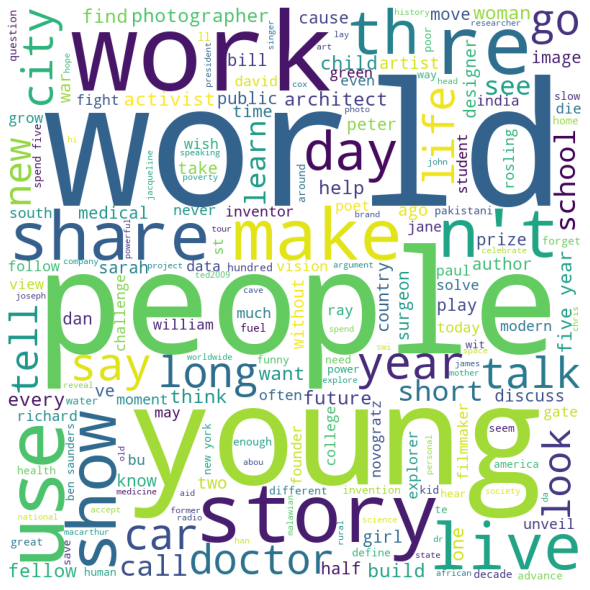

In [88]:
token_topics_string_0 = ' '.join([str(elem) for elem in token_descriptions_0]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_0)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [90]:
wordcloud.to_file("cluster_0.png")

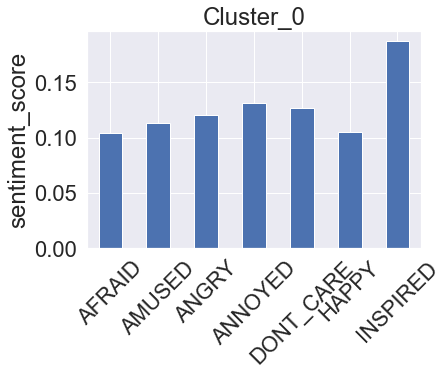

In [166]:
sentiment2.iloc[0,1:8].plot(kind='bar')
plt.title('Cluster_0')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

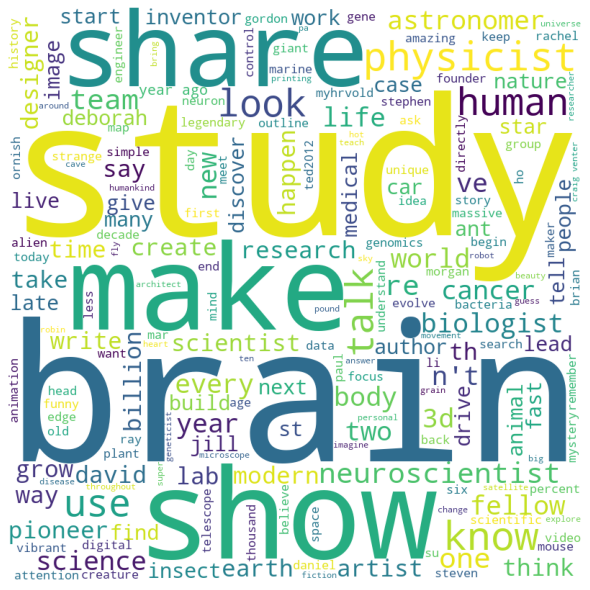

In [91]:
token_topics_string_1 = ' '.join([str(elem) for elem in token_descriptions_1]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_1)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [92]:
wordcloud.to_file("cluster_1.png")

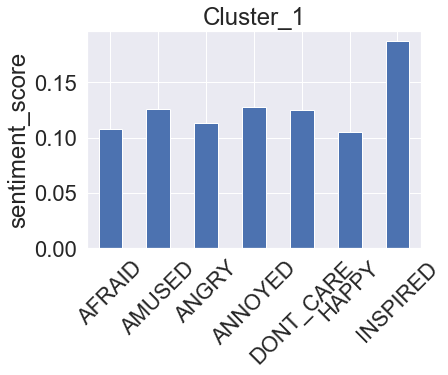

In [167]:
sentiment2.iloc[1,1:8].plot(kind='bar')
plt.title('Cluster_1')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

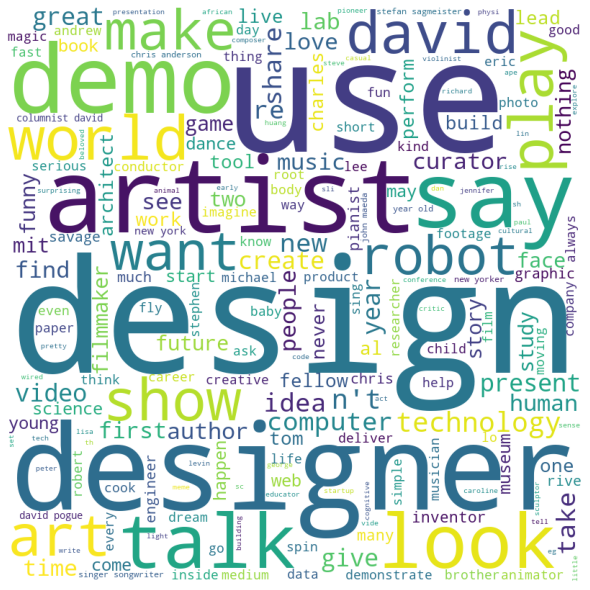

In [93]:
token_topics_string_2 = ' '.join([str(elem) for elem in token_descriptions_2]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_2)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [94]:
wordcloud.to_file("cluster_2.png")

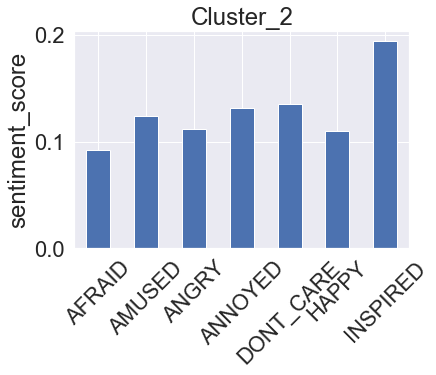

In [168]:
sentiment2.iloc[2,1:8].plot(kind='bar')
plt.title('Cluster_2')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

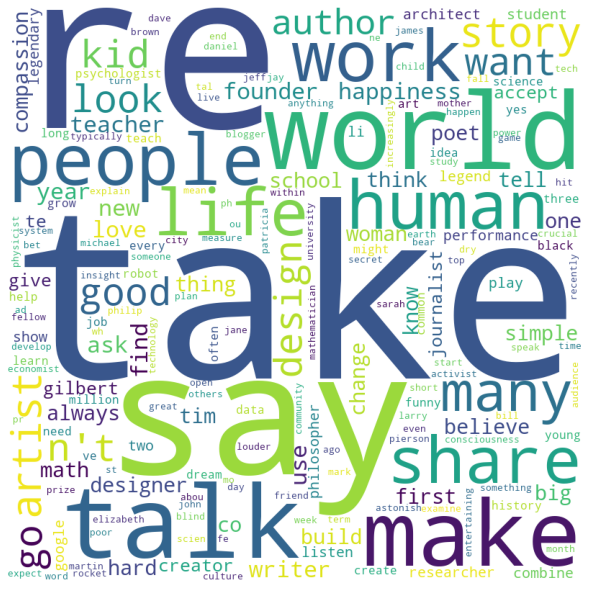

In [95]:
token_topics_string_3 = ' '.join([str(elem) for elem in token_descriptions_3]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_3)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [96]:
wordcloud.to_file("cluster_3.png")

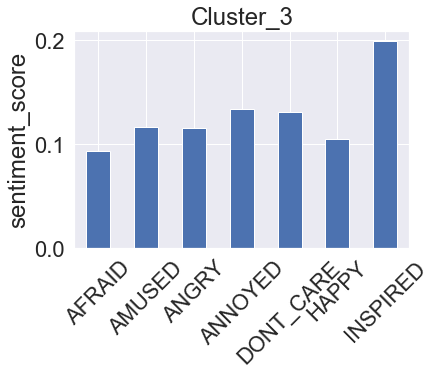

In [169]:
sentiment2.iloc[3,1:8].plot(kind='bar')
plt.title('Cluster_3')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

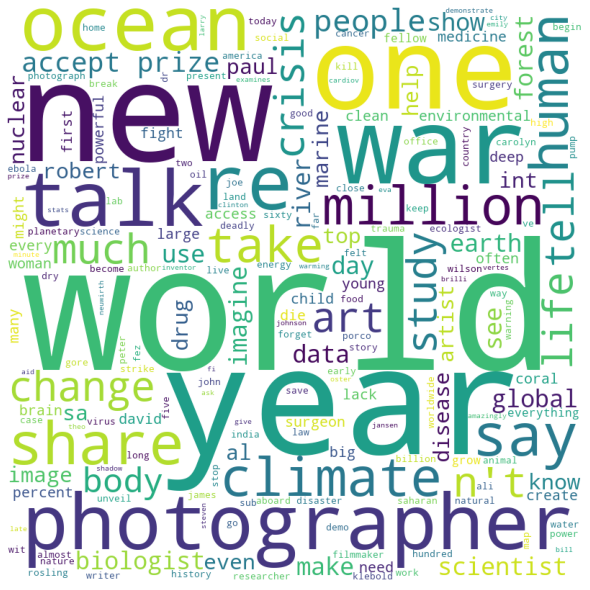

In [97]:
token_topics_string_4 = ' '.join([str(elem) for elem in token_descriptions_4]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_4)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [98]:
wordcloud.to_file("cluster_4.png")

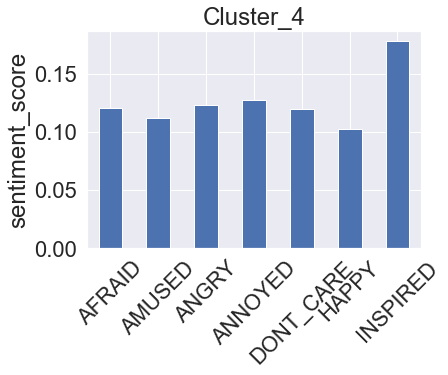

In [170]:
sentiment2.iloc[4,1:8].plot(kind='bar')
plt.title('Cluster_4')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

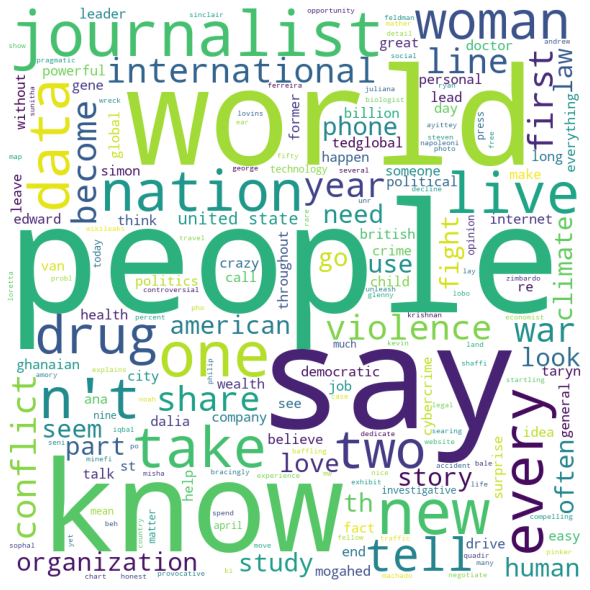

In [99]:
token_topics_string_5 = ' '.join([str(elem) for elem in token_descriptions_5]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_5)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [100]:
wordcloud.to_file("cluster_5.png")

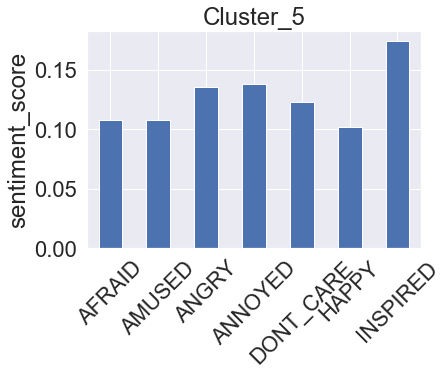

In [171]:
sentiment2.iloc[5,1:8].plot(kind='bar')
plt.title('Cluster_5')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

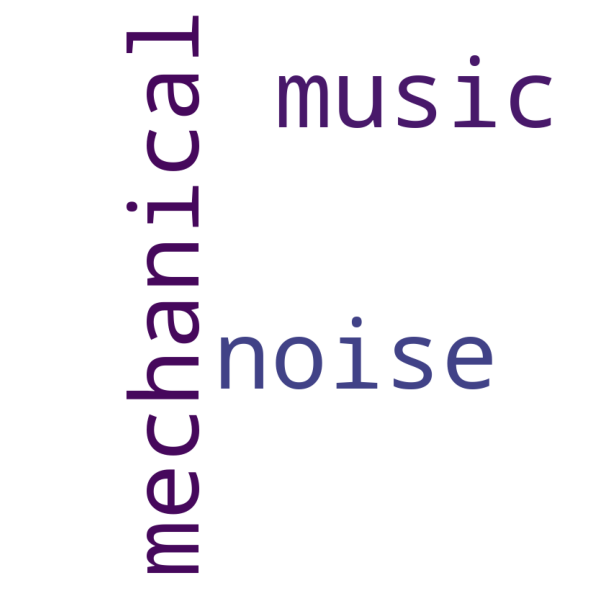

In [103]:
token_topics_string_6 = ' '.join([str(elem) for elem in token_descriptions_6]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_6)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

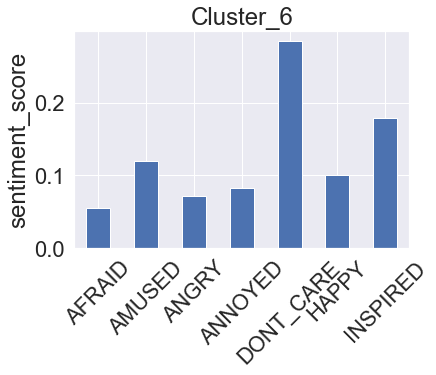

In [172]:
sentiment2.iloc[6,1:8].plot(kind='bar')
plt.title('Cluster_6')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

In [104]:
wordcloud.to_file("cluster_6.png")

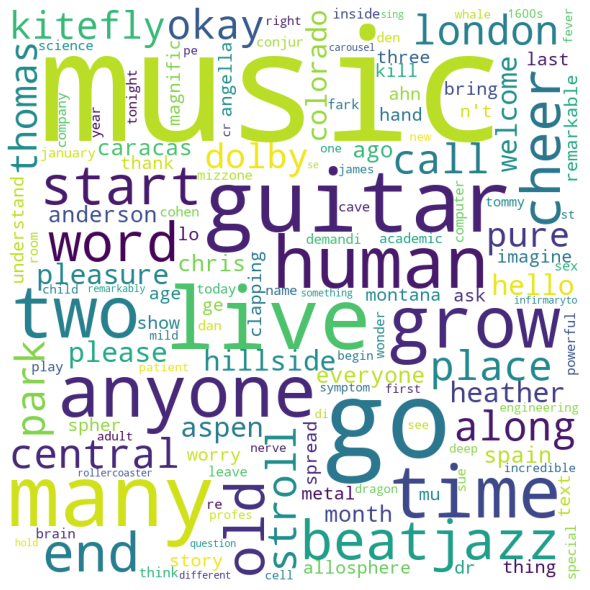

In [105]:
token_topics_string_7 = ' '.join([str(elem) for elem in token_descriptions_7]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_7)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [106]:
wordcloud.to_file("cluster_7.png")

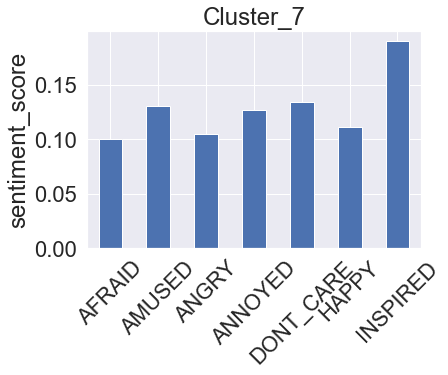

In [173]:
sentiment2.iloc[7,1:8].plot(kind='bar')
plt.title('Cluster_7')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()

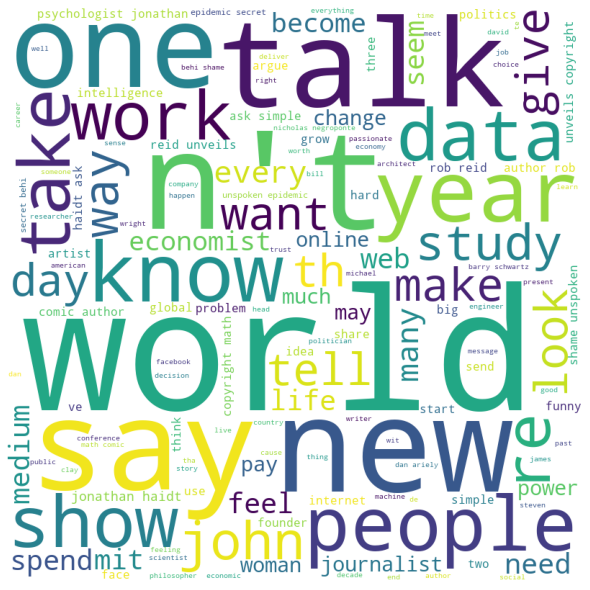

In [107]:
token_topics_string_8 = ' '.join([str(elem) for elem in token_descriptions_8]) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string_8)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [108]:
wordcloud.to_file("cluster_8.png")

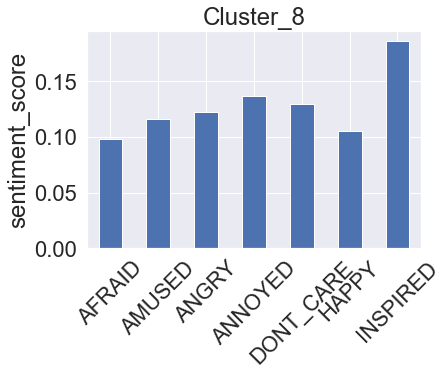

In [174]:
sentiment2.iloc[8,1:8].plot(kind='bar')
plt.title('Cluster_8')
plt.ylabel('sentiment_score')
plt.xticks(rotation=45)
plt.show()